In [1]:
import rfnetwork as rfn
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import mpl_markers as mplm

np.set_printoptions(suppress=True, threshold=12)

# frequency range for plots
frequency = np.arange(350, 550, 5) * 1e6 
f0 = 440e6 # design frequency

def smithchart_marker(ax, fc: float, **properties):
    """ place a smith chart marker by frequency rather than x/y position """
    
    f_idx = np.argmin(np.abs(frequency - fc))
    return mplm.line_marker(
        idx=f_idx, axes=ax, xline=False, yformatter=lambda x, y, idx: f"{frequency[idx]/1e6:.0f}MHz", **properties
)

# Using Voltage Wave Probes

This examples demonstrates how internal probes can be used to tune an amplifier. The amplifier used is a 8W UHF FET 
manufactured by STM, [PD55008-E](https://www.st.com/en/radio-frequency-transistors/pd55008-e.html). 

This amplifier is bilateral ($S_{12}\neq 0$) which can make tuning difficult. Network probes allow the reflection coefficients at the amplifier, $\Gamma_{in}$ and $\Gamma_{out}$, to be plotted while the amplifier is connected to matching networks. In practice, the output load should be tuned for maximum output power and not maximum gain, but
for the purposes of this example, the amplifier is conjugately matched at both input and output.

Start by importing the s-parameter data from the manufacturer. S-parameters are available at multiple different drain
currents, load each of them into a single `Component`.

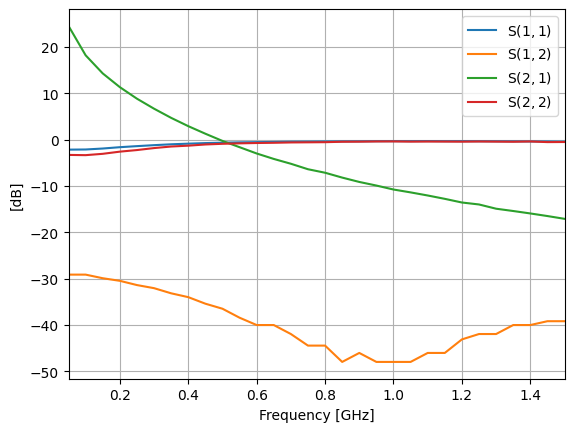

In [2]:
DATA_DIR = Path("data/PD55008E_S_parameter")

pa_8w = rfn.Component_SnP(
    file={
        150: DATA_DIR / "PD55008E_150mA.s2p", 
        800: DATA_DIR / "PD55008E_800mA.s2p", 
        1500: DATA_DIR / "PD55008E_1500mA.s2p"
    }
)

# 50 ohm microstrip model, substrate is from the amplifier evaluation board.
ms50 = rfn.elements.MSLine(
    h=0.030, 
    er=2.55, 
    w=0.08,
    df=0.017,
)

# plot the s-parameters of the untuned device
pa_8w.plot();

## Matching Network

Build a matching network, with the input and output networks contained in their own `Component` class.

In [3]:

# 50 ohm microstrip model, substrate is from the amplifier evaluation board.
ms50 = rfn.elements.MSLine(
    h=0.030, 
    er=2.55, 
    w=0.08,
    df=0.017,
)

class pa_input(rfn.Network):
    """
    Amplifier input matching network
    """
    c1 = rfn.elements.Capacitor(12e-12, shunt=True)
    ms1 = ms50(1.1)
    c2 = rfn.elements.Capacitor(40e-12, shunt=True)
    ms2 = ms50(0.4)
    r1 = rfn.elements.Resistor(2)

    # Port 2 will connect to port 1 of the amplifer
    cascades = [
        ("P1", c1, ms1, c2, ms2, r1, "P2"),
    ]

    probes=True

class pa_output(rfn.Network):
    """
    PA output matching network
    """
    ms3 = ms50(0.4)
    c3 = rfn.elements.Capacitor(65e-12, shunt=True)
    ms4 = ms50(1.1)
    c4 = rfn.elements.Capacitor(15e-12, shunt=True)

    # Port 1 will connect to the amplifier output
    cascades = [
        ("P1", ms3, c3, ms4, c4, "P2"),
    ]
    
    # individual probes can be assigned here, but setting to True
    # creates a probe at every internal node of the network.
    probes=True


class pa_match(rfn.Network):
    """
    Matched amplifier circuit
    """
    m_in = pa_input()
    u1 = pa_8w(file=150)
    m_out = pa_output()

    cascades = [
        ("P1", m_in, u1, m_out, "P2"),
    ]

    probes=True

n = pa_match()

## Internal Reflection Coefficients

The probe data is used to plot the reflection coefficient looking into each component in the network. On the input side, $\Gamma_{in}$ of the amplifier is plotted first and is followed by each the reflection looking into each component that precedes it, until we arrive at S11.

The output side starts at $\Gamma_{out}$, and works back towards S22.

The notation for the legend follows the same convention as S11, or S22. For example, `S(m_in.ms2|1, m_in.c2|2)` is the ratio of the voltage wave leaving port 1 of `ms2` to the voltage wave leaving port 2 of `c2` (which is the same wave that enters `ms2`). The result is the reflection coefficient looking into port 1 of `ms2`.

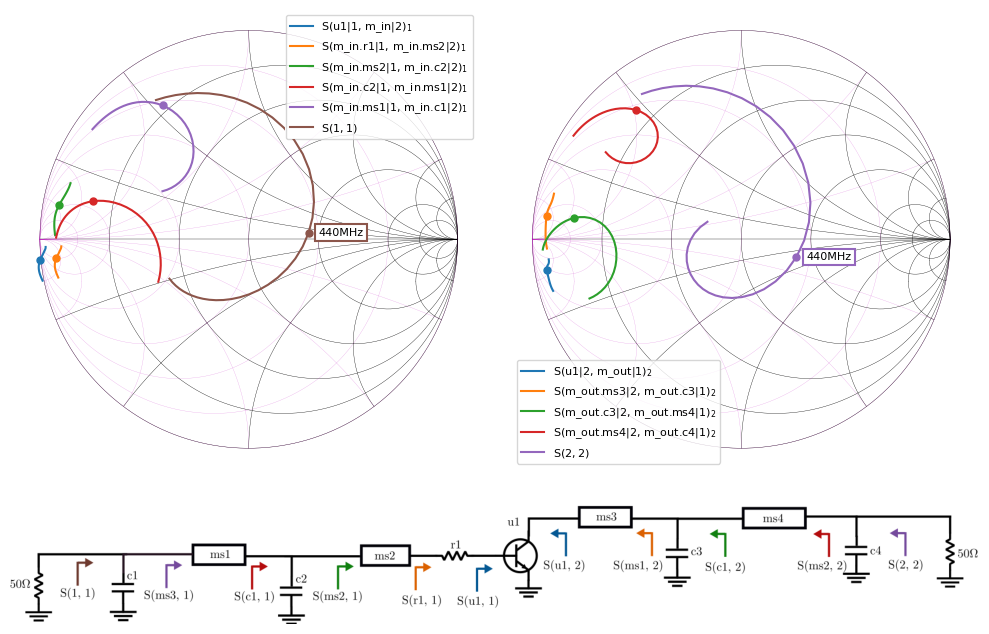

In [4]:

fig, axes = plt.subplot_mosaic(
    [["s11", "s22"], ["im", "im"]], figsize=(10, 7), height_ratios=[1, 0.5]
)

rfn.plots.draw_smithchart(axes["s11"])
rfn.plots.draw_smithchart(axes["s22"])

lines1 = n.plot_probe(
    ("u1|1", "m_in|2"),
    ("m_in.r1|1", "m_in.ms2|2"),
    ("m_in.ms2|1", "m_in.c2|2"),
    ("m_in.c2|1", "m_in.ms1|2"),
    ("m_in.ms1|1", "m_in.c1|2"),
    input_port=1, fmt="smith", tune=True,
    axes=axes["s11"],
    frequency=frequency,
)

ln_s11 = n.plot(11, fmt="smith", tune=True, axes=axes["s11"], frequency=frequency)
axes["s11"].legend(fontsize=8)

smithchart_marker(axes["s11"], f0, lines=lines1, ylabel=False)
smithchart_marker(axes["s11"], f0, lines=ln_s11)

lines2 = n.plot_probe(
    ("u1|2", "m_out|1"),
    ("m_out.ms3|2", "m_out.c3|1"),
    ("m_out.c3|2", "m_out.ms4|1"),
    ("m_out.ms4|2", "m_out.c4|1"),
    input_port=2, fmt="smith", tune=True,
    axes=axes["s22"],
    frequency=frequency,
)

ln_s22 = n.plot(22, fmt="smith", tune=True, axes=axes["s22"], frequency=frequency)
axes["s22"].legend(fontsize=8)

smithchart_marker(axes["s22"], f0, lines=lines2, ylabel=False)
smithchart_marker(axes["s22"], f0, lines=ln_s22)


im = plt.imread("data/img/pa_tuning.png")
axes["im"].imshow(im)
axes["im"].set_axis_off()

fig.tight_layout()

## Stability 

Plot the source and load stability circles, along with the conjugate input impedance for the output matching network.

Since $|S_{22}|$ and $|S_{11}|$ of the untuned amplifier are both $<1$, the unstable region is inside the circles.

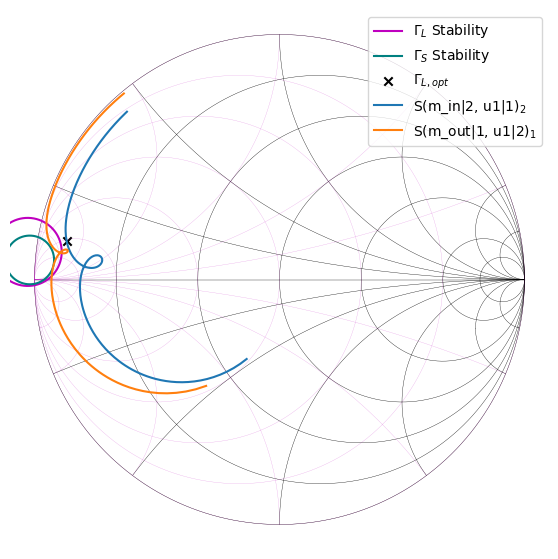

In [5]:
f_wide = np.arange(50, 1500, 5) * 1e6 

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
rfn.plots.draw_smithchart(ax)

s_circ, l_circ = rfn.plots.stability_circles(pa_8w.evaluate(f0)["s"].sel(frequency=f0))

l_line = ax.plot(l_circ.real, l_circ.imag, label=r"$\Gamma_L$ Stability", color="m")
s_line = ax.plot(s_circ.real, s_circ.imag, label=r"$\Gamma_S$ Stability", color="teal")

# plot the conjugate match for S22 of the amplifier
s22 = pa_8w.evaluate(f0)["s"].sel(b=2, a=2)
ax.scatter(np.conj(s22).real, np.conj(s22).imag, marker="x", color="k", label=r"$\Gamma_{L, opt}$")


gamma_S = n.plot_probe(
    ("m_in|2", "u1|1"), input_port=2, fmt="smith", axes=ax, frequency=f_wide, 
)

gamma_L = n.plot_probe(
    ("m_out|1", "u1|2"), input_port=1, fmt="smith", axes=ax, frequency=f_wide, 
)

## Gain

Finally, plot the gain of the tuned amplifier.

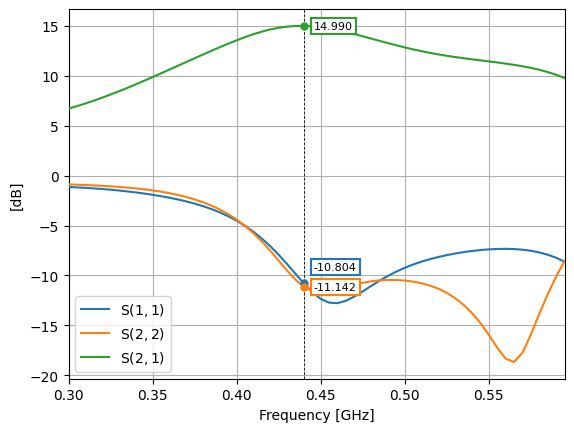

In [6]:
f_gain = np.arange(300, 600, 5) * 1e6 

n.plot(11, 22, 21, fmt="db", frequency=f_gain)
mplm.line_marker(x=f0/1e9)